# Notebook exercise 12 

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

/Users/giovannichini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Reshape data and convert labels to be used with categorical cross entropy

In [3]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [5]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model(optimizer='SGD'):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 32
epochs = 15

# create the deep neural net
model_DNN = compile_model(optimizer=SGD)

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          verbose=0, validation_data=(X_test, Y_test))

/Users/giovannichini/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - acc: 0.9676 - loss: 0.1046

Test loss: 0.08891961723566055
Test accuracy: 0.9724000096321106


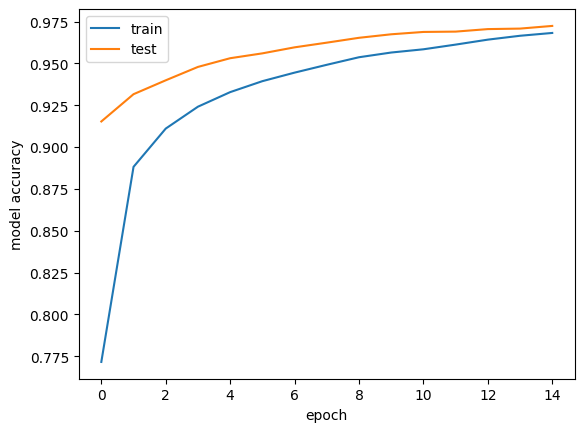

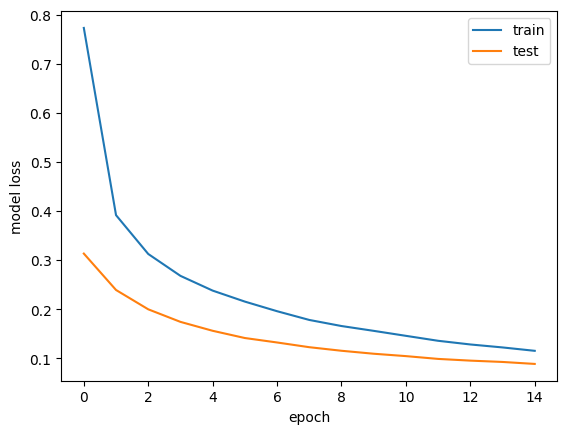

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


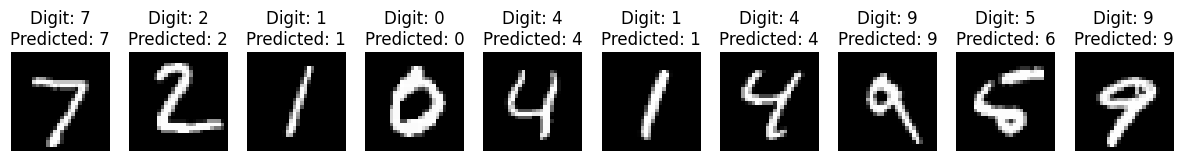

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

## 12.1

### Assignment

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

### Solution 




I try to use three different optimizer called ```SDG```,```Adamax``` and ```Nadam```. For all of them i train the DNN using three different number of epoch. In the figure below I report the trend fore the loss and accuracy in all the case. As expected, I find that the precision of the network improve increasing $N_{epochs}$, then I find that the best optimizer in this case seems to be ```Adamax```.

/Users/giovannichini/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - acc: 0.9431 - loss: 0.1858
SGD with 5 epochs:
Test loss: 0.15721775591373444
Test accuracy: 0.9531000256538391
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - acc: 0.9604 - loss: 0.1279
SGD with 10 epochs:
Test loss: 0.1102728396654129
Test accuracy: 0.9656000137329102
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - acc: 0.9666 - loss: 0.1015
SGD with 15 epochs:
Test loss: 0.08820971101522446
Test accuracy: 0.9713000059127808
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - acc: 0.9711 - loss: 0.0957
Adamax with 5 epochs:
Test loss: 0.0821988433599472
Test accuracy: 0.9745000004768372
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - acc: 0.9763 - loss: 0.0749
Adamax with 10 epochs:
Test loss: 0.06279249489307404
Test accuracy: 0.9804999828338623
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - acc: 0.9780 - loss: 0.0748
Adamax with 15 epochs:
Test loss: 0.06202499568462372
Test accuracy: 0.9818000197410583
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - acc: 0.9

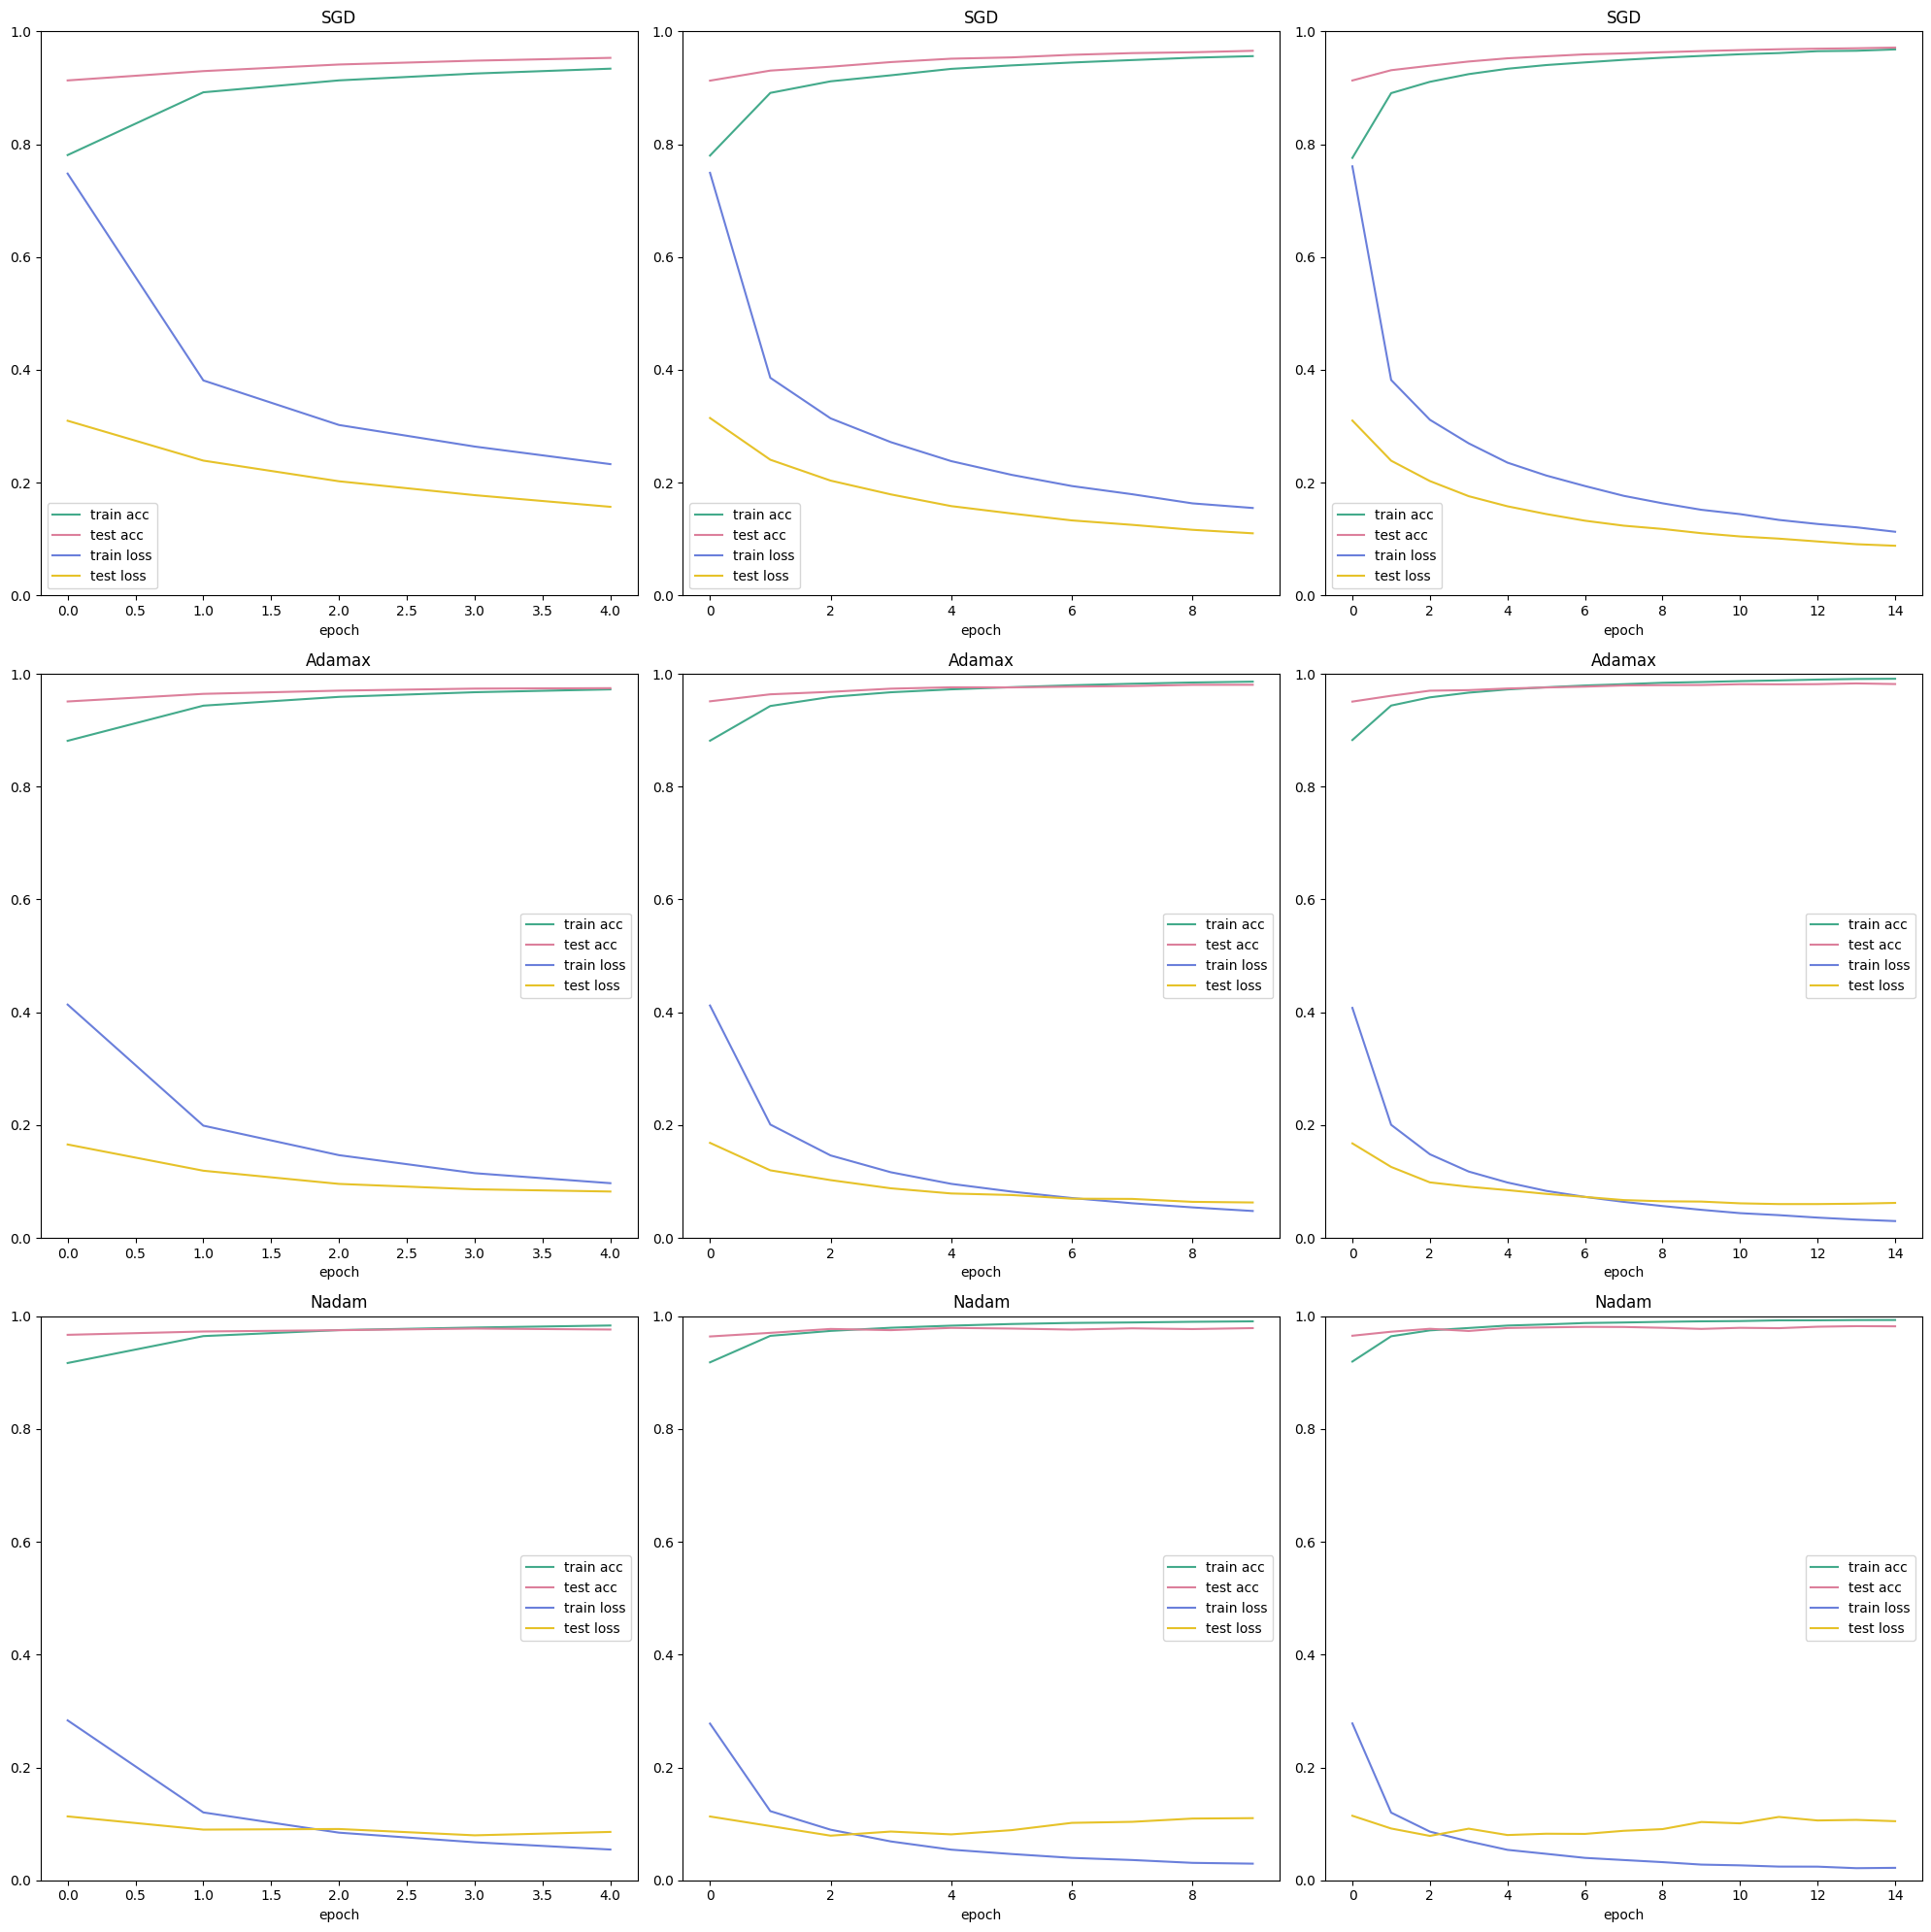

In [13]:
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# training parameters
batch_size = 32
optimizer =[SGD, Adamax, Nadam]
epochs = [5, 10, 15]
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i in range(3):
    for j in range(3):
        # create the deep neural net
        model_DNN = compile_model(optimizer[i])

        # train DNN and store training info in history
        history = model_DNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs[j], shuffle=True, verbose=0, validation_data=(X_test, Y_test))
        # evaluate model
        score = model_DNN.evaluate(X_test, Y_test, verbose=1)

        # print performance
        print(optimizer[i].__name__, 'with', epochs[j], 'epochs:')
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        ax = axes[i,j]
        # summarize history for accuracy
        ax.set_title(optimizer[i].__name__)
        ax.plot(history.history['acc'], color = '#43AA8B')
        ax.plot(history.history['val_acc'], color = '#DC7F9B')
        #summarize history for loss
        ax.plot(history.history['loss'], color = '#6A7FDB')
        ax.plot(history.history['val_loss'], color = '#E6C229')

        ax.set_xlabel('epoch')
        ax.set_ylim(0,1)
        ax.legend(['train acc', 'test acc', 'train loss', 'test loss'], loc='best')

plt.tight_layout()
plt.show()

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [14]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

## 12.2 

### Assignment 

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

### Solution 

I create a new Neural Network using convolutional layers. Below the next cell are plotted its architecture, I add two pooling layer and two convolutional layer. 

This type of layer are very useful to process image data, because make a NN able to recognize an object in the image independently on its position. In this layer some filters are applied to the image, then the final result is flattened and used in a normal deep neural network. Below the summary of the model I plotted the rapresentation of the filter used in the network.  

CNN model architecture created successfully!


/Users/giovannichini/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 10)     │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 20)       │         5,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,390 (95.27 KB)

 Trainable params: 24,390 (95.27 KB)

 Non-trainable params: 0 (0.00 B)

(5, 5, 1, 10)


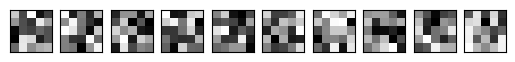

In [15]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2))) # add max pooling layer
    # add second convolutional layer with 20 filters
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # add max pooling layer
    # flatten the output of the last layer
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(50, activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(50, activation='relu'))    
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    print('CNN model architecture created successfully!')
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adamax',
                  metrics=['acc'])
    return model


# create the deep conv net
model_CNN=create_CNN()
model_CNN.summary()

# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

Then I train the network with the MNIST dataset, using 15 epochs. In the figure are reported the accuracy and the loss trend, which show the convergence of the training process.

In [16]:
# training parameters
batch_size = 32
epochs = 15 

# train CNN
history_2 = model_CNN.fit(X_train, Y_train,batch_size=batch_size, 
          epochs=epochs, verbose=0, validation_data=(X_test, Y_test))



Test loss: 0.03240032494068146
Test accuracy: 0.9901000261306763


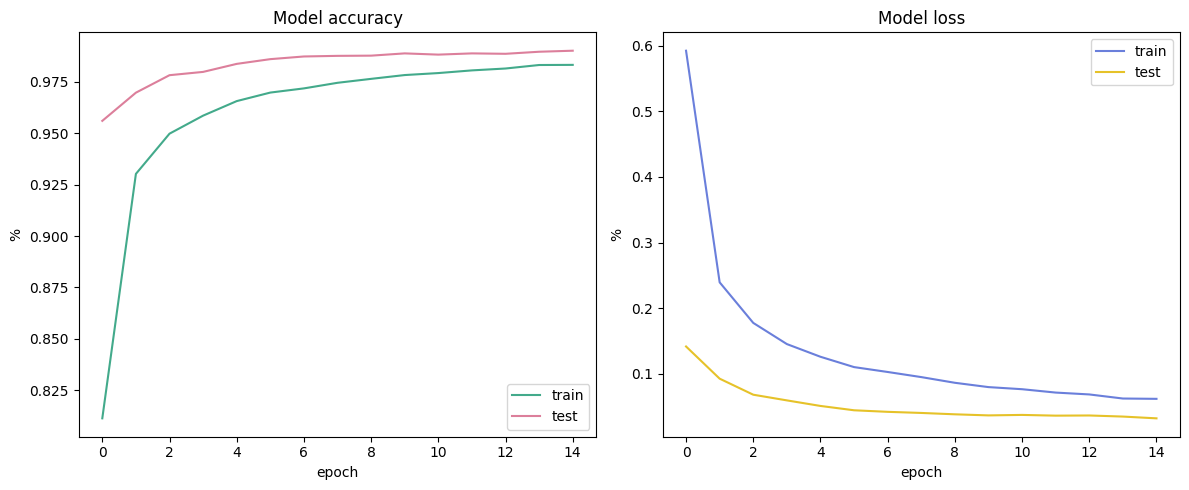

In [17]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 2, figsize=(12,5))
# summarize history for accuracy
ax[0].plot(history_2.history['acc'], color='#43AA8B')
ax[0].plot(history_2.history['val_acc'], color='#DC7F9B')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel(r'$\%$')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='best')

# summarize history for loss
ax[1].plot(history_2.history['loss'], color='#6A7FDB')
ax[1].plot(history_2.history['val_loss'], color='#E6C229')
ax[1].set_title('Model loss')
ax[1].set_ylabel(r'$\%$')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best')

plt.tight_layout()
plt.show()

I tested the accuracy of the network using some new image of the MNIST dataset. From this exaple the NN seems to be very precise, in fact it predict correctly all the image proposed. 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


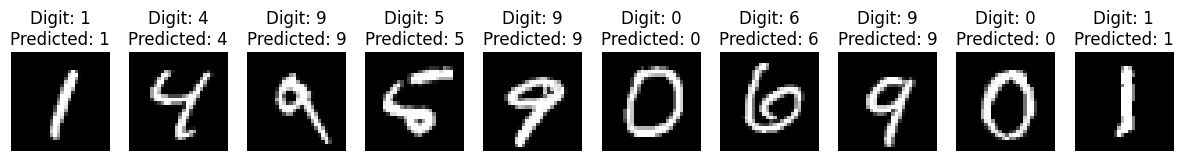

In [18]:
predictions = model_CNN.predict(X_test)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i+5, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i+5]), np.argmax(predictions[i+5])))    
    plt.axis('off') 
plt.show()


## 12.3

### Assignment

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

### Solution 

Finally I test the accuracy of the network with some image created by myself, using ```gimp``` application. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


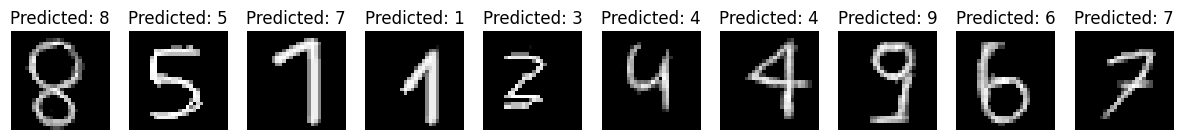

In [19]:
from PIL import Image
import os

data_tot = np.zeros((10, 28, 28, 1)) # array to store the images

for i in range(10):
    filename = "number/gimp_"+str(i)+".png"
    image = Image.open(filename).convert('L')
    ydim, xdim = image.size
    pix=image.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for k in range(xdim):
            data[k,j]=pix[j,k]
    data /= 255
    data_reshaped = data.reshape(28, 28, 1)
    data_tot[i] = data_reshaped 
    
pred = model_CNN.predict(data_tot)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data_tot[i, :, :, 0], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(pred[i]))) 
    plt.axis('off') 
plt.show()

Also in this case the Network seems to be precise, in fact it predicts all the number except the third. In this image I write number 1 and the network read it as a 7. Probably this error is caused by the fact that the slope of the upper line is low, so it can be interpreted as a number 7 rotated. In conclusion this error seems to demonstrate that the CNN is more precise than me in interpreting numbers. 